# NLP Cipher Decoder #

## Import files & APIs ##

In [1]:
!wget -nc https://lazyprogrammer.me/course_files/moby_dick.txt

File 'moby_dick.txt' already there; not retrieving.



In [2]:
import numpy as np
import matplotlib.pyplot as plt

import string
import random
import re

In [3]:
!head moby_dick.txt

In [4]:
original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

## Generate random substitution cipher ##

In [5]:
letters1 = list(string.ascii_lowercase)
letters2 = list(string.ascii_lowercase)

true_mapping = {}

random.shuffle(letters2)

for k, v in zip(letters1, letters2):
    true_mapping[k] = v

## Create character-level language model ##

In [6]:
# Initialize initial state distribution
pi = np.ones(26)

# Initialize Markov matrix
M = np.ones((26, 26))

In [7]:
# Functions to update pi and M
def update_transition(ch1, ch2):
    i = ord(ch1) - ord('a')
    j = ord(ch2) - ord('a')
    M[i, j] += 1

def update_pi(ch):
    i = ord(ch) - ord('a')
    pi[i] += 1

In [8]:
# Function that gets the log-probability of a word
def get_word_prob(word):
    i = ord(word[0]) - ord('a')
    logp = np.log(pi[i])
    
    for ch in word[1:]:
        j = ord(ch) - ord('a')
        logp += np.log(M[i, j])
        i = j
    return logp

In [9]:
# Function that gets the log-probability of a sequence of words
def get_sequence_prob(words):
    if type(words) == str:
        words = words.split()
    
    logp = 0
    for word in words:
        logp += get_word_prob(word)
    return logp

In [10]:
# Fill in unigrams and bigrams
regex = re.compile('[^a-zA-Z]')

for line in open("moby_dick.txt", "r"):
    line = line.rstrip().lower()
    if line:
        line = regex.sub(' ', line)
        tokens = line.split()
        for token in tokens:
            ch0 = token[0]
            update_pi(ch0)
            
            for ch1 in token[1:]:
                update_transition(ch0, ch1)
                ch0 = ch1

In [11]:
# Normalize unigrams and bigrams
pi /= pi.sum()
M /= M.sum(axis=1, keepdims=True)

## Encoding & decoding functions ##

In [12]:
def encode(msg):
    encoded_msg = ""
    for ch in msg.lower():
        encoded_msg += true_mapping[ch] if ch in true_mapping else ' '
    return encoded_msg

In [13]:
def decode(msg, word_map):
    decoded_msg = ""
    for ch in msg:
        decoded_msg += word_map[ch] if ch in word_map else ch
    return decoded_msg

## Genetic algorithm ##

In [14]:
# Generates a given number of random ciphers
def get_many_random_dna(num):
    dna_pool = []
    for _ in range(num):
        dna = list(string.ascii_lowercase)
        random.shuffle(dna)
        dna_pool.append(dna)
    return dna_pool

In [15]:
# Appends a given number of offspring with different mutations to an existing pool of ciphers
def create_offspring(dna_pool, num_offspring):
    offspring = []
    
    for dna in dna_pool:
        for _ in range(num_offspring):
            copy = dna.copy()
            j = np.random.randint(len(copy))
            k = np.random.randint(len(copy))
            
            temp = copy[j]
            copy[j] = copy[k]
            copy[k] = temp
            offspring.append(copy)

    return offspring + dna_pool

In [16]:
def find_best_cipher(encoded_msg, num_iters):
    dna_pool = get_many_random_dna(20)
    scores = np.zeros(num_iters)
    best_dna = None
    best_map = None
    best_score = float("-inf")
    for i in range(num_iters):
        if i > 0:
            dna_pool = create_offspring(dna_pool, 3)

        dna2score = {}
        for dna in dna_pool:
            current_map = {}
            for k, v in zip(letters1, dna):
                current_map[k] = v
            
            decoded_msg = decode(encoded_msg, current_map)
            score = get_sequence_prob(decoded_msg)
            
            dna2score[''.join(dna)] = score
            
            if score > best_score:
                best_dna = dna
                best_map = current_map
                best_score = score
        
        scores[i] = np.mean(list(dna2score.values()))
        
        sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse=True)
        dna_pool = [list(k) for k, v in sorted_dna[:5]]
        
        if i % 200 == 0:
            print("iter:", i, "score:", scores[i], "best so far:", best_score)
    return best_map, scores

## Test predicted cipher ##

In [17]:
encoded_msg = encode(original_message)

In [18]:
predicted_cipher, scores = find_best_cipher(encoded_msg, 1000)

iter: 0 score: -2002.6281818465425 best so far: -1709.1472792066586
iter: 200 score: -1052.3328431094594 best so far: -973.1501465672288
iter: 400 score: -1077.4260490565878 best so far: -941.532058463559
iter: 600 score: -1022.9208398979397 best so far: -941.532058463559
iter: 800 score: -1012.2117545281562 best so far: -941.532058463559


In [19]:
decoded_msg = decode(encoded_msg, predicted_cipher)

In [20]:
print("Original message:\n", original_message)
print("Encoded message:\n", encoded_msg, "\n")
print("Decoded message:\n", decoded_msg, "\n")

Original message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.

Encoded message:
 w cbip nvupxiy yvkp cbi dcfiic hpy tvupy  hd w izrijciy  cbhc cbifi khd h likd wp h nhpi kbwjb fupd yvkp me vpi khnn vt cbi xhfyip  w nipc cbi vdcnifd h bhpy wp fummwpx yvkp cbiwf bvfdid  hpy fijiwqiy wp izjbhpxi ckvripji  h xnhdd vt bhnt hpy bhnt  ckv twnnd vt dbhx cvmhjjv  hpy hd lujb wptvflhcwvp hd w jvuny yidwfi hmvuc lwdd hynif  cv dhe pvcbwpx vt bhnt h yvaip vcbif rivrni wp cbi piwxbmvufbvvy wp kbvl w khd pvc wp cbi nihdc wpcifidciy  muc kbvdi mwvxfhrbwid 

## Analysis ##

In [21]:
# Find log-likelihood of decoded message and original message
print("LL of decoded message:", get_sequence_prob(decoded_msg))
print("LL of true message:", get_sequence_prob(regex.sub(' ', original_message.lower())))
print()

# Find letters that are wrong in predicted cipher
print("Wrong letters:")
for true, v in true_mapping.items():
    pred = predicted_cipher[v]
    if true != pred:
        print("true: %s, pred: %s" % (true, pred))

LL of decoded message: -941.532058463559
LL of true message: -933.0339420615785

Wrong letters:
true: b, pred: f
true: f, pred: y
true: k, pred: q
true: q, pred: z
true: y, pred: b
true: z, pred: k


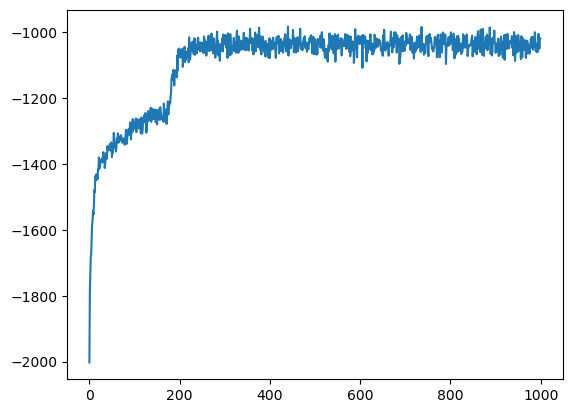

In [22]:
plt.plot(scores)
plt.show()